アンサンブルをしてもスコアが上がらない。もう一度初心に立ち帰り、特徴量エンジニアリングを行う。

特徴量をチェックするシート

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib

訓練データの読み込み

In [914]:
house_age = pd.read_csv('house_age.csv')
area_size = pd.read_csv('area_size.csv')
room_arrange = pd.read_csv('room_arrange.csv')
contract_span = pd.read_csv('contract_span.csv')
floor_scores = pd.read_csv('floor_scores.csv')
Floor_scores = pd.read_csv('capital_floor_scores.csv')
stations = pd.read_csv('stations.csv')
minits = pd.read_csv('minits.csv')
addresses = pd.read_csv('addresses.csv')
room_arrange = pd.read_csv('room_arrange.csv')

rent = pd.read_csv('rent.csv')

テストデータの読み込み

In [915]:
test_house_age = pd.read_csv('test_house_age.csv')
test_area_size = pd.read_csv('test_area_size.csv')
test_room_arrange = pd.read_csv('test_room_arrange.csv')
test_contract_span = pd.read_csv('test_contract_span.csv')
test_floor_scores = pd.read_csv('test_floor_scores.csv')
test_Floor_scores = pd.read_csv('test_capital_floor_scores.csv')
test_stations = pd.read_csv('test_stations.csv')
test_minits = pd.read_csv('test_minits.csv')
test_addresses = pd.read_csv('test_addresses.csv')
test_room_arrange = pd.read_csv('test_room_arrange.csv')

築年数(house_ageについて)

/var/folders/qh/20ftf7rn5_58_rk3l25kt1nr0000gn/T/ipykernel_6423/2180439461.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


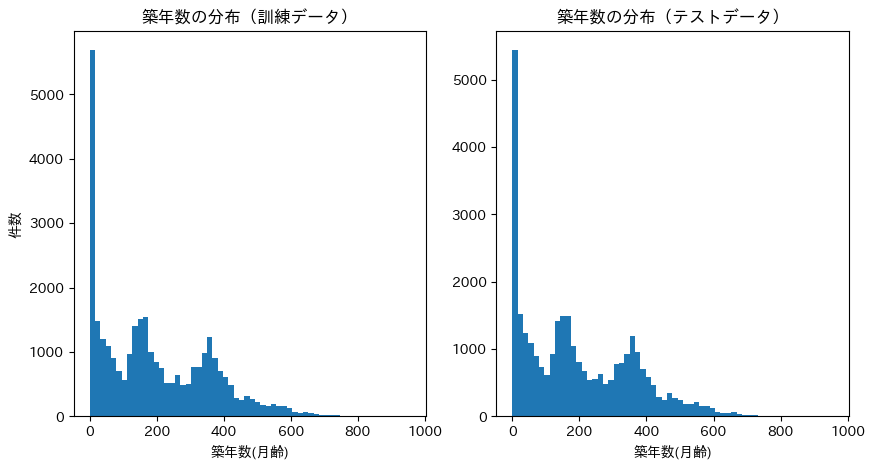

In [916]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.hist(house_age,bins=60)
ax1.set_title('築年数の分布（訓練データ）')
ax1.set_xlabel('築年数(月齢)')
ax1.set_ylabel('件数')

ax2.hist(test_house_age,bins=60)
ax2.set_title('築年数の分布（テストデータ）')
ax2.set_xlabel('築年数(月齢)')

fig.show()

- ここから得られる知見として、築年数ごとの件数でピークがいくつかあるということ。
- 新築の物件が極めて多いこと。

築年数の大きいものが少し怪しい気がするので確かめる。

In [917]:
house_age[house_age['築年数']>800]

築年数
11994  835.0
13755  819.0
15352  955.0
16506  823.0
17090  819.0
21985  830.0
24000  847.0

元データを確認したところ、築800か月(約70年)超えの物件は少ないながら存在しているのでそのままにする。

面積について

/var/folders/qh/20ftf7rn5_58_rk3l25kt1nr0000gn/T/ipykernel_6423/1120412897.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


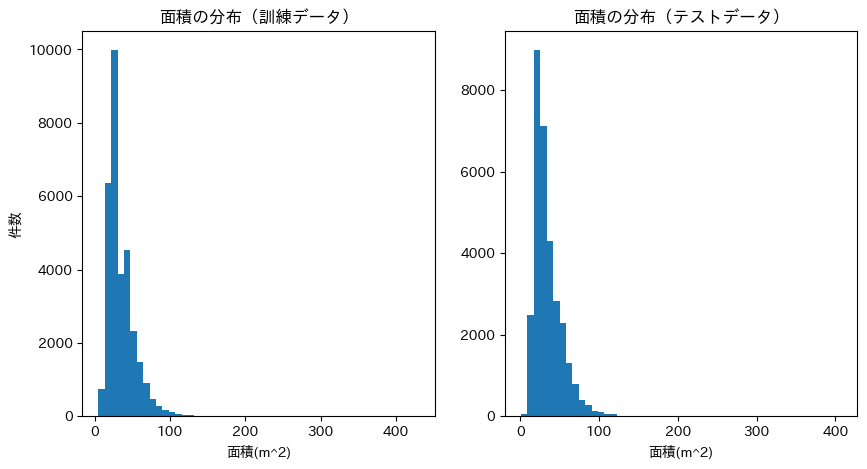

In [918]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.hist(area_size,bins=50)
ax1.set_title('面積の分布（訓練データ）')
ax1.set_xlabel('面積(m^2)')
ax1.set_ylabel('件数')

ax2.hist(test_area_size,bins=50)
ax2.set_title('面積の分布（テストデータ）')
ax2.set_xlabel('面積(m^2)')

fig.show()

面積が大きすぎるものもあるので確認する。

In [919]:
area_size[area_size['面積'] > 200]

面積
671    231.52
1295   214.78
1771   232.01
2075   256.68
5093   217.29
9008   223.71
10334  214.77
11958  221.30
16613  270.07
16847  221.30
18249  259.31
20926  430.10
25951  231.52
30539  341.30

欠損値の処理を見直してみる。

まず自分で欠損値の処理をテキトーにしていた意識があるのは、契約期間である。

In [920]:
contract_span.isna().sum()

契約期間    104
dtype: int64

現在の契約期間データの問題点として、
- 以前は、元ファイルで欠損値になっていたものに0を代入していた。しかしこれでは、モデルに間違った解釈をさせかねない。
- 異常値対策として、契約期間が10年以上のものに対してはnanを代入していた。しかし、例えば1000年のような明らかな異常値はあるものの、15年などのような値も元ファイルに存在している。
- 定期借家情報が抜け落ちている。

これらを修正する。

In [5]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df = pd.concat([df_train, df_test],axis=0)
merge_contract_span = df["契約期間"]
merge_contract_span.head()

0                       2年間
1                       2年間
2                       2年間
3    2年間\t※この物件は\t定期借家\tです。
4                       2年間
Name: 契約期間, dtype: object

In [6]:
merge_contract_span.isna().sum()

14101

必ずしも以前の契約期間データが間違っているとは言い切れないので、再利用も考慮に入れて、contract_span2のようにナンバリングする。

In [7]:
i = 0
target = '年'
target2 = 'ヶ'
merge_reg_rent = []
merge_contract_span2 = []
for contract_span in merge_contract_span:
    ##定期借家かどうかチェックする。    
    try:
        if '定期借家' in contract_span:
            merge_reg_rent.append(1)
        else:
            merge_reg_rent.append(0)
    except:
        merge_reg_rent.append(nan)

    ##以下は契約期間に関する記述。
    #sが欠損値であることに備える。
    try:
        idx = contract_span.find(target)
    except:
        #sが欠損値であればidxの取得が失敗するので、今までは0を代入していた。
        #今回はnanで代入する。
        merge_contract_span2.append(nan)
        i += 1
        continue
    
    try:
        #年単位で契約期間が定まっているのかをまず調べる
        if float( contract_span[:idx] ) > 50.0:
            merge_contract_span2.append(nan)
        else:
            merge_contract_span2.append( float( contract_span[:idx] ) )
    except:
        #月単位で契約期間が定まっているのなら、12で割って契約年数とする。
        idx2 = contract_span.find(target2)
        if float( contract_span[:idx2] )/12 > 50.0:
            merge_contract_span2.append(nan)
        else:
            merge_contract_span2.append(float( contract_span[:idx2] )/12)

    i += 1

In [8]:
merge_reg_rent = pd.DataFrame(merge_reg_rent)

In [9]:
contract_span2 = merge_contract_span2[:len(df_train['契約期間'])]
test_contract_span2 = merge_contract_span2[len(df_train['契約期間']):]
reg_rent = merge_reg_rent[:len(df_train['契約期間'])]
test_reg_rent = merge_reg_rent[len(df_train['契約期間']):]

In [10]:
contract_span2 = pd.DataFrame(contract_span2)
contract_span2.columns = ['契約期間']
contract_span2.to_csv('contract_span2.csv',index=False)
test_contract_span2 = pd.DataFrame(test_contract_span2)
test_contract_span2.to_csv('test_contract_span2.csv',index=False)

#定期借家はカテゴリ変数
reg_rent = pd.DataFrame(reg_rent)
reg_rent.columns = ['定期借家']
list_cols = ['定期借家']
reg_rent_encoder = ce.OrdinalEncoder(cols=list_cols, drop_invariant=True)
reg_rent = reg_rent_encoder.fit_transform(reg_rent['定期借家'])
reg_rent.to_csv('reg_rent.csv',index=False)

test_reg_rent = pd.DataFrame(test_reg_rent)
test_reg_rent.columns = ['定期借家']
test_reg_rent = pd.DataFrame(test_reg_rent)
test_reg_rent_encoder = ce.OrdinalEncoder(cols=list_cols, drop_invariant=True)
test_reg_rent = test_reg_rent_encoder.fit_transform(test_reg_rent['定期借家'])
test_reg_rent.to_csv('test_reg_rent.csv',index=False)

次に、「所在地」のカテゴリを振り直す。

In [927]:
#所在地のテキスト整形用関数
def func_place(block):
    target2 = '丁'
    target3 = '町'
    target4 = '-'
    target5 = '－'
    try:
        if target2 in block:
            place = block.split(target2)[0]
            if place == '新宿区余':
                place = '新宿区余丁町'
            else:
                place = place[:-1]
        elif target3 in block:
            place = block.split(target3)[0]
            place = place + target3
        elif target4 in block:
            place = block.split(target4)[0]
            place = place[:-1]
        elif target5 in block:
            place = block.split(target5)[0]
            place = place[:-1]
        if place[-1].isnumeric():
            place = place[:-1]
        return place
    except:
            return block

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df = pd.concat([df_train, df_test],axis=0)

locations = df['所在地']

#以下の部分では訓練データの”区”のラベル化に備えて、〇〇区の部分を抽出する。
i = 0
merge_addresses = []
for loc in locations:
    target1 = "都"
    idx1 = loc.find(target1)
    block = loc[idx1+1:]
    address = func_place(block)
    merge_addresses.append(address)

merge_addresses = pd.DataFrame(merge_addresses)
merge_addresses = merge_addresses.rename(columns={0:'所在地'})#列名の振り直し
print("カテゴリ化前の訓練データ：")
print("カテゴリ化前の訓練データの大きさ：",len(merge_addresses))
merge_addresses.to_csv('merge_address.csv')

#カテゴリ化
list_cols = ['所在地']
addresses_encoder = ce.OrdinalEncoder(cols=list_cols, drop_invariant=True)
merge_addresses_c = addresses_encoder.fit_transform(merge_addresses['所在地'])
#訓練データとテストデータに再分割
addresses = merge_addresses_c[:len(df_train)]
addresses.to_csv('addresses.csv',index=False)
test_addresses = merge_addresses_c[len(df_train):]
test_addresses.to_csv('test_addresses.csv',index=False)

カテゴリ化前の訓練データ：
カテゴリ化前の訓練データの大きさ： 62732


In [928]:
merge_addresses['所在地']

0          北区滝野川
1          中央区月島
2          渋谷区笹塚
3        杉並区高円寺南
4          葛飾区金町
          ...   
62727     豊島区上池袋
62728    千代田区岩本町
62729     中野区江古田
62730    千代田区二番町
62731     大田区南馬込
Name: 所在地, Length: 62732, dtype: object

In [929]:
#所在地が何回登場しているか数える。少ない回数しか登場していないものは整形ミスの可能性があり怪しい。
addresses_sr = pd.Series(merge_addresses['所在地'])
vc = addresses_sr.value_counts()
vc = pd.DataFrame(vc)
vc.columns = ['登場回数']
#登場回数が3回以下のものはファイル出力して記録する。
errors_list = vc[vc['登場回数'] <= 3]
errors_list.to_csv('errors_list.csv')

これまでに整形したデータでlightBGMを動かしてみる。

スコアの向上が望めそうである。

さらにチューニングをする。

次に「所在階」と「全体の階数」も再検討する。これまでは、「所在階」と「全体の階数」のどちらか一方が欠けていた場合は、両方とも欠損扱いしていたので、今回はどちらか片方だけでも情報を取り出す。

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df = pd.concat([df_train, df_test], axis=0).reset_index()#インデックス振り直し
merge_n_floor2 = df

i = 0
target0 = '階'
target1 = '／'
target2 = '建'
target3 = '下'
for s in merge_n_floor2:
    if (s == '建物構造'):
        continue

    ###floor(その部屋のある階数)とFloor(全体の階数)を設定する。


    ##まずはfloor（その部屋のある階数）から求める
    
    idx1 = s.find(target1)#"／"の位置を取得する。"／"がなければ-1が返る。

    if (idx1 == 0):#"／"の位置が先頭なら、その部屋の階数情報は不明だから欠損値にいれて無視する。
        merge_n_floor2[i] = nan
        i += 1
        continue

    if (idx1 == -1):#"／"がない場合
        #考えうるのは単に"〇階建"や"地下〇階"という文字列だけが入力されている場合である。
        if (s.find(target2)!=-1):#"〇階建"の場合
            #n_floor2[i] = nan#肝心なのは、その部屋が何階にあるかだと思うので、あえて欠損値を入力しておく。
            floor = nan
            idx0 = s.find(target0)
            print(i)
            print(s)
            Floor = int(s[:idx0])
            merge_n_floor2[i] = [floor,Floor]
            i += 1
            continue
        elif (s.find(target3)!=-1):
            idx0 = s.find(target0)
            idx3 = s.find(target3)
            floor = - int( s[idx3:idx0+1] )#"地下〇階"の〇の部分を取得する。
            Floor = nan#全体の階数は不明なので欠損値にしておく。 
            merge_n_floor2[i] = [floor,Floor]
            i += 1
            continue
        else:#"／"がなく、かつ"〇階建"や"地下〇階"の形式ではないものはもう無視する
            merge_n_floor2[i] = nan
            i += 1
            continue

    try:
        floor = int( s[:idx1-1] )#"〇階／"における〇の値の取得を試みる。idx1-1であることに注意。

    except:#exceptで受けるのは"〇階／"のあとにも文字列がある場合。例えば"地下〇階／"など。
        if (s.find(target3)!=-1):#もし"地下〇階／"の形式である場合
            idx1 = s.find(target1)
            idx3 = s.find(target3)
            floor = - int( s[idx3+1:idx1-1] )#"地下〇階／"の〇の部分を取得する
        else:
            merge_n_floor2[i] = nan#それ以外の場合は欠損値をいれて無視する。
    

    ##次にFloor(全体の階数)を求める
    idx2 = s.find(target2)

    try:#"／〇階建"の〇の部分の取得を試みる。
        Floor = int ( s[idx1+1:idx2-1] )
    except:#tryで失敗するものには欠損値を入れて無視する
        Floor = nan

    merge_n_floor2[i] = [floor,Floor]
    i += 1

n_floor2 = merge_n_floor2[:len(df_train)]
n_floor2.to_csv("n_floor2.csv",index=False)
test_n_floor2 = merge_n_floor2[len(df_train):]
test_n_floor2.to_csv("test_n_floor2.csv",index=False)


df_train = pd.read_csv('n_floor2.csv')
df_test = pd.read_csv('test_n_floor2.csv')
df = pd.concat([df_train, df_test], axis=0).reset_index()#インデックス振り直し
n_floor = df

i = 0
for s in n_floor["所在階"]:
    try:
        n_floor["所在階"][i] = re.findall(r"\d+", s)
        #print(n_floor["所在階"][i])
    except:
        n_floor["所在階"][i] = nan
        #print("koko")
    i += 1


merge_floor_scores = []
merge_Floor_scores = []
for n in n_floor["所在階"]:
    print(n)
    #所在階についての部分
    try:
        floor_score = int(n[0])
    except:
        floor_score = nan
    #全体の階数について
    try:
        Floor_score = int(n[1])
    except:
        Floor_score = nan
    merge_floor_scores.append(floor_score)
    merge_Floor_scores.append(Floor_score)

merge_floor_scores = pd.Series(data=merge_floor_scores, name='所在階')
merge_Floor_scores = pd.Series(data=merge_Floor_scores, name='全体の階数')

#ナンバリングしているのは、今までの「所在階・全体の階数」情報が必ずしも間違っているとは言い切れないと考えられるため。
floor_scores2 = merge_floor_scores[:len(df_train)]
floor_scores2.to_csv("floor_scores2.csv",index=False)
test_floor_scores2 = merge_floor_scores[len(df_train):]
test_floor_scores2.to_csv("test_floor_scores2.csv",index=False)

Floor_scores2 = merge_Floor_scores[:len(df_train)]
Floor_scores2.to_csv("capital_floor_scores2.csv",index=False)
test_Floor_scores2 = merge_Floor_scores[len(df_train):]
test_Floor_scores2.to_csv("test_capital_floor_scores2.csv",index=False)

C:\Users\koshi\AppData\Local\Temp\ipykernel_4156\1532639003.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_floor["所在階"][i] = re.findall(r"\d+", s)
C:\Users\koshi\AppData\Local\Temp\ipykernel_4156\1532639003.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_floor["所在階"][i] = nan


['1', '12']
['5', '10']
['12', '15']
['3', '4']
['1', '2']
['6', '12']
['6', '8']
['1', '6']
['4', '9']
['2', '3']
['1', '6']
['1', '2']
['6', '10']
['3', '3']
['4', '11']
['4', '5']
['2', '5']
['1', '2']
['5', '11']
['8', '12']
['2']
['7', '10']
['10', '42']
['4', '5']
['2', '4']
['1', '2']
['12', '12']
['2', '2']
['10', '10']
['1', '10']
['4', '11', '1']
['1', '2']
['3', '3']
['3', '7']
['4', '10']
['1', '2']
['2', '3']
['8', '15']
['4', '11']
['2']
['2', '7', '1']
['3', '5']
['3', '4', '2']
['1', '3']
['4', '4']
['7', '9']
['2', '5']
['11', '13']
['1', '2']
['4', '8']
['2', '2']
['1', '3']
['7', '10']
['2', '3']
['6', '6']
['1', '4']
['11', '14']
['13', '15']
['9', '12']
['3', '6']
['3', '3']
['4', '5']
['4', '11']
['3', '3']
['4', '5']
['10', '11']
['3', '4']
['3', '4']
['5', '10']
['2', '2']
['2', '3']
['1', '2']
['2', '5']
['1', '3']
['2', '2']
['2', '4']
['2', '3']
['3', '4']
['1', '4']
['4', '5']
['2', '3']
['3', '4']
['1', '2']
['2']
['4', '8']
['9', '12']
['2', '5']
['1', '3'

lightGBMにこの新しい「所在階」と「全体の階数」を加える。

In [ ]:
X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, addresses, room_arrange], axis=1)
y_train = rent

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_addresses, test_room_arrange], axis=1)

category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D', 'K']
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

params = {
    'objective':'regression',
    'metrics':'rmse',
    'reg_lambda': 6.616511445042975e-05,
    'max_bin': 514,
    'num_leaves': 99
}

model = lgb.train(
                    params,
                    lgb_train, 
                    valid_sets=[lgb_train, lgb_eval], 
                    verbose_eval=10, 
                    num_boost_round=3000, 
                    early_stopping_rounds=10,
                    categorical_feature = category_lists
                    )

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2364
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 35410.5	valid_1's rmse: 40954.5
[20]	training's rmse: 20982.9	valid_1's rmse: 29989.8
[30]	training's rmse: 15706.8	valid_1's rmse: 26168.2
[40]	training's rmse: 13360.6	valid_1's rmse: 24626.7
[50]	training's rmse: 12056.6	valid_1's rmse: 23885.2
[60]	training's rmse: 11033.2	valid_1's rmse: 23345.5
[70]	training's rmse: 10226.8	valid_1's rmse: 22974.5
[80]	training's rmse: 9569.97	valid_1's rmse: 22679
[90]	training's rmse: 8988.27	valid_1's rmse: 22419.5
[100]	training's rmse: 8550.33	valid_1's 

良い感じである。最後のひとおしのチューニングをする。

In [ ]:
X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, addresses, room_arrange], axis=1)
y_train = rent

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_addresses, test_room_arrange], axis=1)

def objective(trial):
    category_lists = ['定期借家', '最寄り駅', '所在地', 'L', 'D', 'K', 'S']
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    params = {
        'objective':'regression',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0000001, 0.0001, log=True),
        'max_bin': trial.suggest_int('max_bin', 255, 600),
        'num_leaves': trial.suggest_int('num_leaves', 50, 128),
    }

    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        #verbose_eval=10, 
                        num_boost_round=3000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists
                        )

    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)

    loss = mean_squared_error(y_valid, y_pred_valid, squared=False)
    return loss

In [ ]:
# study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
# study.optimize(objective, n_trials=40)
# study.best_params

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2341
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70607.7	valid_1's rmse: 71336.7
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67764.5	valid_1's rmse: 68775.4
[3]	training's rmse: 65075.5	valid_1's rmse: 66357.3
[4]	training's rmse: 62535.5	valid_1's rmse: 64099.5
[5]	training's rmse: 60117.5	valid_1's rmse: 61994.9
[6]	training's rmse: 57856.9	valid_1's rmse: 59976.6
[7]	training's rmse: 55700.6	valid_1's rmse: 58124.8
[8]	training's rmse: 53683.1	valid_1's rmse: 56350.6
[9]	training's rmse: 51768.9	valid_1's rmse: 54719.2
[10]	training's rmse: 49971	valid_1's rmse: 5316

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2111
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70602.3	valid_1's rmse: 71335.8
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67708.5	valid_1's rmse: 68695.2
[3]	training's rmse: 64979.8	valid_1's rmse: 66242.4
[4]	training's rmse: 62443.2	valid_1's rmse: 63971.9
[5]	training's rmse: 60056.2	valid_1's rmse: 61842.3
[6]	training's rmse: 57737.1	valid_1's rmse: 59784.2
[7]	training's rmse: 55602.9	valid_1's rmse: 57924.3
[8]	training's rmse: 53585.6	valid_1's rmse: 56187.6
[9]	training's rmse: 51634.7	valid_1's rmse: 54485.9
[10]	training's rmse: 49822.8	valid_1's rmse: 52

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2463
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70538.7	valid_1's rmse: 71246.5
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67639.9	valid_1's rmse: 68622
[3]	training's rmse: 64893.9	valid_1's rmse: 66141.4
[4]	training's rmse: 62306.9	valid_1's rmse: 63827.2
[5]	training's rmse: 59860.3	valid_1's rmse: 61644.3
[6]	training's rmse: 57531.3	valid_1's rmse: 59612.3
[7]	training's rmse: 55352.4	valid_1's rmse: 57720.7
[8]	training's rmse: 53287	valid_1's rmse: 55931.4
[9]	training's rmse: 51315.5	valid_1's rmse: 54215.7
[10]	training's rmse: 49465.4	valid_1's rmse: 52638


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2393
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70575.8	valid_1's rmse: 71316.6
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67715.5	valid_1's rmse: 68715.3
[3]	training's rmse: 65007.7	valid_1's rmse: 66282
[4]	training's rmse: 62455.1	valid_1's rmse: 64016.9
[5]	training's rmse: 60001.2	valid_1's rmse: 61809.8
[6]	training's rmse: 57698.8	valid_1's rmse: 59786.3
[7]	training's rmse: 55521.3	valid_1's rmse: 57824
[8]	training's rmse: 53473.4	valid_1's rmse: 56059.2
[9]	training's rmse: 51547.2	valid_1's rmse: 54360.9
[10]	training's rmse: 49723.2	valid_1's rmse: 52785


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2487
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70628.5	valid_1's rmse: 71331.2
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67809.4	valid_1's rmse: 68789.7
[3]	training's rmse: 65147.2	valid_1's rmse: 66387.7
[4]	training's rmse: 62635.6	valid_1's rmse: 64143.1
[5]	training's rmse: 60263.2	valid_1's rmse: 62009.4
[6]	training's rmse: 58021.2	valid_1's rmse: 60031.7
[7]	training's rmse: 55898.8	valid_1's rmse: 58170.7
[8]	training's rmse: 53893.6	valid_1's rmse: 56466.3
[9]	training's rmse: 52013.3	valid_1's rmse: 54835.3
[10]	training's rmse: 50211.6	valid_1's rmse: 53

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1826
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70544.2	valid_1's rmse: 71238.7
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67632.3	valid_1's rmse: 68583.3
[3]	training's rmse: 64891.2	valid_1's rmse: 66094.6
[4]	training's rmse: 62297.9	valid_1's rmse: 63734.3
[5]	training's rmse: 59857.3	valid_1's rmse: 61538.2
[6]	training's rmse: 57549.8	valid_1's rmse: 59473.2
[7]	training's rmse: 55385.7	valid_1's rmse: 57572.8
[8]	training's rmse: 53328.1	valid_1's rmse: 55787.1
[9]	training's rmse: 51379.8	valid_1's rmse: 54102.1
[10]	training's rmse: 49551.6	valid_1's rmse: 52

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2449
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70528.9	valid_1's rmse: 71232.4
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67631	valid_1's rmse: 68669.4
[3]	training's rmse: 64882.9	valid_1's rmse: 66177
[4]	training's rmse: 62295.7	valid_1's rmse: 63887.3
[5]	training's rmse: 59835.8	valid_1's rmse: 61713.9
[6]	training's rmse: 57499.9	valid_1's rmse: 59639.2
[7]	training's rmse: 55332.7	valid_1's rmse: 57769.2
[8]	training's rmse: 53252.4	valid_1's rmse: 55981.8
[9]	training's rmse: 51286.6	valid_1's rmse: 54303.4
[10]	training's rmse: 49434.2	valid_1's rmse: 52741


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2150
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70548.6	valid_1's rmse: 71259.9
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67686.3	valid_1's rmse: 68692.6
[3]	training's rmse: 64947.8	valid_1's rmse: 66214.5
[4]	training's rmse: 62382.8	valid_1's rmse: 63914.7
[5]	training's rmse: 59968.9	valid_1's rmse: 61766.5
[6]	training's rmse: 57638	valid_1's rmse: 59692
[7]	training's rmse: 55502.3	valid_1's rmse: 57820.4
[8]	training's rmse: 53440.8	valid_1's rmse: 56014.9
[9]	training's rmse: 51531.9	valid_1's rmse: 54366.7
[10]	training's rmse: 49731.5	valid_1's rmse: 52824.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2289
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70622.3	valid_1's rmse: 71330.7
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67802.1	valid_1's rmse: 68758.8
[3]	training's rmse: 65126.3	valid_1's rmse: 66354.3
[4]	training's rmse: 62592.6	valid_1's rmse: 64074.4
[5]	training's rmse: 60224.5	valid_1's rmse: 61989.5
[6]	training's rmse: 57991.6	valid_1's rmse: 60033.2
[7]	training's rmse: 55901.2	valid_1's rmse: 58180.3
[8]	training's rmse: 53906.3	valid_1's rmse: 56457.4
[9]	training's rmse: 52007.4	valid_1's rmse: 54803
[10]	training's rmse: 50206.9	valid_1's rmse: 5323

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2207
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70623	valid_1's rmse: 71363.4
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67778.8	valid_1's rmse: 68798.3
[3]	training's rmse: 65100	valid_1's rmse: 66407.1
[4]	training's rmse: 62578.5	valid_1's rmse: 64153.9
[5]	training's rmse: 60194.3	valid_1's rmse: 62033.7
[6]	training's rmse: 57878.9	valid_1's rmse: 59962.6
[7]	training's rmse: 55765	valid_1's rmse: 58115.5
[8]	training's rmse: 53766.9	valid_1's rmse: 56387.5
[9]	training's rmse: 51885.3	valid_1's rmse: 54761.9
[10]	training's rmse: 50017.1	valid_1's rmse: 53117.1


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2381
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70582.4	valid_1's rmse: 71315.5
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67725.6	valid_1's rmse: 68733.5
[3]	training's rmse: 65033.9	valid_1's rmse: 66316.9
[4]	training's rmse: 62435.9	valid_1's rmse: 63965.9
[5]	training's rmse: 60010.9	valid_1's rmse: 61828.3
[6]	training's rmse: 57727.1	valid_1's rmse: 59829.2
[7]	training's rmse: 55573.3	valid_1's rmse: 57891.9
[8]	training's rmse: 53542.4	valid_1's rmse: 56133.5
[9]	training's rmse: 51633.7	valid_1's rmse: 54485.3
[10]	training's rmse: 49815.3	valid_1's rmse: 52

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1826
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70557.7	valid_1's rmse: 71247.9
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67659.5	valid_1's rmse: 68609.6
[3]	training's rmse: 64933.3	valid_1's rmse: 66141.2
[4]	training's rmse: 62351.2	valid_1's rmse: 63790.6
[5]	training's rmse: 59923.9	valid_1's rmse: 61597.2
[6]	training's rmse: 57622.5	valid_1's rmse: 59535.5
[7]	training's rmse: 55462.7	valid_1's rmse: 57639.5
[8]	training's rmse: 53432.6	valid_1's rmse: 55863
[9]	training's rmse: 51516.7	valid_1's rmse: 54220.3
[10]	training's rmse: 49713.9	valid_1's rmse: 5266

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2273
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70532.8	valid_1's rmse: 71203.4
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67620	valid_1's rmse: 68520.2
[3]	training's rmse: 64873.3	valid_1's rmse: 66003.7
[4]	training's rmse: 62293.9	valid_1's rmse: 63706.1
[5]	training's rmse: 59830.2	valid_1's rmse: 61512
[6]	training's rmse: 57518.8	valid_1's rmse: 59453.5
[7]	training's rmse: 55331.3	valid_1's rmse: 57529.7
[8]	training's rmse: 53267	valid_1's rmse: 55727.5
[9]	training's rmse: 51320.9	valid_1's rmse: 54052.8
[10]	training's rmse: 49461.1	valid_1's rmse: 52437
[1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2062
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70580.3	valid_1's rmse: 71285.4
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67718.9	valid_1's rmse: 68683
[3]	training's rmse: 64996.3	valid_1's rmse: 66267.4
[4]	training's rmse: 62413.5	valid_1's rmse: 63997.9
[5]	training's rmse: 59988.1	valid_1's rmse: 61825.3
[6]	training's rmse: 57699.9	valid_1's rmse: 59833.4
[7]	training's rmse: 55537	valid_1's rmse: 57952.1
[8]	training's rmse: 53508.9	valid_1's rmse: 56190.2
[9]	training's rmse: 51574.4	valid_1's rmse: 54477.7
[10]	training's rmse: 49761.7	valid_1's rmse: 52897.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1854
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70555.9	valid_1's rmse: 71285.2
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67669.8	valid_1's rmse: 68654.8
[3]	training's rmse: 64940.7	valid_1's rmse: 66179.1
[4]	training's rmse: 62367.6	valid_1's rmse: 63866.4
[5]	training's rmse: 59934.8	valid_1's rmse: 61647.8
[6]	training's rmse: 57624.6	valid_1's rmse: 59564
[7]	training's rmse: 55452.8	valid_1's rmse: 57629.5
[8]	training's rmse: 53405.2	valid_1's rmse: 55807
[9]	training's rmse: 51485.5	valid_1's rmse: 54119.7
[10]	training's rmse: 49646.5	valid_1's rmse: 52509.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1958
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70643.6	valid_1's rmse: 71385.3
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67857.5	valid_1's rmse: 68872.9
[3]	training's rmse: 65229.3	valid_1's rmse: 66507.5
[4]	training's rmse: 62751.7	valid_1's rmse: 64256.8
[5]	training's rmse: 60382.3	valid_1's rmse: 62134
[6]	training's rmse: 58160.5	valid_1's rmse: 60129.3
[7]	training's rmse: 56054.9	valid_1's rmse: 58267
[8]	training's rmse: 54089.6	valid_1's rmse: 56508.2
[9]	training's rmse: 52207.9	valid_1's rmse: 54847.5
[10]	training's rmse: 50397.3	valid_1's rmse: 53243.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2064
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70568	valid_1's rmse: 71273.8
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67671.3	valid_1's rmse: 68682.8
[3]	training's rmse: 64950.3	valid_1's rmse: 66206.1
[4]	training's rmse: 62357.6	valid_1's rmse: 63906.5
[5]	training's rmse: 59916	valid_1's rmse: 61761.8
[6]	training's rmse: 57619.7	valid_1's rmse: 59766.1
[7]	training's rmse: 55456.5	valid_1's rmse: 57813.5
[8]	training's rmse: 53420.5	valid_1's rmse: 56047.2
[9]	training's rmse: 51468.2	valid_1's rmse: 54359.8
[10]	training's rmse: 49638.2	valid_1's rmse: 52741


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70615	valid_1's rmse: 71328.2
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67786.7	valid_1's rmse: 68745.7
[3]	training's rmse: 65116.3	valid_1's rmse: 66325.8
[4]	training's rmse: 62580.1	valid_1's rmse: 64049.7
[5]	training's rmse: 60182.5	valid_1's rmse: 61903.6
[6]	training's rmse: 57931.9	valid_1's rmse: 59910.8
[7]	training's rmse: 55808.5	valid_1's rmse: 58034.7
[8]	training's rmse: 53809.5	valid_1's rmse: 56286.1
[9]	training's rmse: 51924.7	valid_1's rmse: 54666.7
[10]	training's rmse: 50122.9	valid_1's rmse: 5311

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1924
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70600.8	valid_1's rmse: 71315.3
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67756	valid_1's rmse: 68749.9
[3]	training's rmse: 65079.3	valid_1's rmse: 66326.6
[4]	training's rmse: 62517.4	valid_1's rmse: 64034.3
[5]	training's rmse: 60104.4	valid_1's rmse: 61870.5
[6]	training's rmse: 57823.4	valid_1's rmse: 59797.2
[7]	training's rmse: 55673.2	valid_1's rmse: 57901.4
[8]	training's rmse: 53649.3	valid_1's rmse: 56094.4
[9]	training's rmse: 51731.1	valid_1's rmse: 54393.7
[10]	training's rmse: 49897.6	valid_1's rmse: 5278

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2156
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70596.7	valid_1's rmse: 71304.8
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67783	valid_1's rmse: 68750.2
[3]	training's rmse: 65131.8	valid_1's rmse: 66381.3
[4]	training's rmse: 62569.5	valid_1's rmse: 64086
[5]	training's rmse: 60188.9	valid_1's rmse: 61974.7
[6]	training's rmse: 57897.2	valid_1's rmse: 59949.3
[7]	training's rmse: 55745.4	valid_1's rmse: 58038.7
[8]	training's rmse: 53768.3	valid_1's rmse: 56298.1
[9]	training's rmse: 51876	valid_1's rmse: 54649.2
[10]	training's rmse: 50065.3	valid_1's rmse: 53117.1


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1890
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70602.8	valid_1's rmse: 71317.7
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67765.6	valid_1's rmse: 68758.6
[3]	training's rmse: 65066.1	valid_1's rmse: 66309.2
[4]	training's rmse: 62534.3	valid_1's rmse: 64063.8
[5]	training's rmse: 60132.9	valid_1's rmse: 61906
[6]	training's rmse: 57868.6	valid_1's rmse: 59895.9
[7]	training's rmse: 55723.1	valid_1's rmse: 57980
[8]	training's rmse: 53708.4	valid_1's rmse: 56239.8
[9]	training's rmse: 51805.6	valid_1's rmse: 54532.2
[10]	training's rmse: 50013.3	valid_1's rmse: 52996.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1950
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70627.5	valid_1's rmse: 71345.8
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67805.1	valid_1's rmse: 68800.9
[3]	training's rmse: 65122	valid_1's rmse: 66352.3
[4]	training's rmse: 62588.5	valid_1's rmse: 64061.7
[5]	training's rmse: 60197.6	valid_1's rmse: 61924.9
[6]	training's rmse: 57932.4	valid_1's rmse: 59869.4
[7]	training's rmse: 55813.3	valid_1's rmse: 57980
[8]	training's rmse: 53807.6	valid_1's rmse: 56177.7
[9]	training's rmse: 51899.6	valid_1's rmse: 54481.5
[10]	training's rmse: 50116.1	valid_1's rmse: 52925.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1880
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70587.7	valid_1's rmse: 71307.7
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67736.9	valid_1's rmse: 68734.3
[3]	training's rmse: 65029	valid_1's rmse: 66276.9
[4]	training's rmse: 62484.3	valid_1's rmse: 64014.9
[5]	training's rmse: 60071.1	valid_1's rmse: 61847.7
[6]	training's rmse: 57792.8	valid_1's rmse: 59825.4
[7]	training's rmse: 55643.5	valid_1's rmse: 57919
[8]	training's rmse: 53616.2	valid_1's rmse: 56137.4
[9]	training's rmse: 51709.6	valid_1's rmse: 54452
[10]	training's rmse: 49890.4	valid_1's rmse: 52887.9


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2519
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70584.4	valid_1's rmse: 71324.4
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67714.9	valid_1's rmse: 68709.5
[3]	training's rmse: 65011.1	valid_1's rmse: 66292.9
[4]	training's rmse: 62448.3	valid_1's rmse: 63972.3
[5]	training's rmse: 60003.9	valid_1's rmse: 61812
[6]	training's rmse: 57708.6	valid_1's rmse: 59798.5
[7]	training's rmse: 55545.9	valid_1's rmse: 57904.3
[8]	training's rmse: 53500.4	valid_1's rmse: 56128.1
[9]	training's rmse: 51563.4	valid_1's rmse: 54454.5
[10]	training's rmse: 49709.4	valid_1's rmse: 5284

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70543.4	valid_1's rmse: 71211.9
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67641.5	valid_1's rmse: 68542.6
[3]	training's rmse: 64908	valid_1's rmse: 66041.1
[4]	training's rmse: 62336.3	valid_1's rmse: 63745.3
[5]	training's rmse: 59885.6	valid_1's rmse: 61559.3
[6]	training's rmse: 57578.2	valid_1's rmse: 59500.7
[7]	training's rmse: 55395.4	valid_1's rmse: 57590.9
[8]	training's rmse: 53357.8	valid_1's rmse: 55831.1
[9]	training's rmse: 51424.2	valid_1's rmse: 54155.6
[10]	training's rmse: 49564.6	valid_1's rmse: 5255

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2008
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70641.2	valid_1's rmse: 71426.5
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67840.8	valid_1's rmse: 68925.7
[3]	training's rmse: 65195	valid_1's rmse: 66529
[4]	training's rmse: 62704	valid_1's rmse: 64319
[5]	training's rmse: 60342	valid_1's rmse: 62206.3
[6]	training's rmse: 58094.2	valid_1's rmse: 60221.5
[7]	training's rmse: 55994.2	valid_1's rmse: 58408
[8]	training's rmse: 53971.8	valid_1's rmse: 56627.4
[9]	training's rmse: 52107.4	valid_1's rmse: 54994
[10]	training's rmse: 50336.5	valid_1's rmse: 53450
[11]	train

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1896
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70629.5	valid_1's rmse: 71337.6
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67826.1	valid_1's rmse: 68809.2
[3]	training's rmse: 65154.8	valid_1's rmse: 66367.9
[4]	training's rmse: 62659	valid_1's rmse: 64153.6
[5]	training's rmse: 60276	valid_1's rmse: 61984.9
[6]	training's rmse: 58038.6	valid_1's rmse: 59989.9
[7]	training's rmse: 55929	valid_1's rmse: 58083.9
[8]	training's rmse: 53948.7	valid_1's rmse: 56354
[9]	training's rmse: 52068.4	valid_1's rmse: 54702.6
[10]	training's rmse: 50278.8	valid_1's rmse: 53165
[11]

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1858
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70554.2	valid_1's rmse: 71281.6
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67666.5	valid_1's rmse: 68650.7
[3]	training's rmse: 64935.4	valid_1's rmse: 66176.4
[4]	training's rmse: 62361.1	valid_1's rmse: 63861.1
[5]	training's rmse: 59927.1	valid_1's rmse: 61640.6
[6]	training's rmse: 57615.7	valid_1's rmse: 59556.1
[7]	training's rmse: 55442.7	valid_1's rmse: 57623.2
[8]	training's rmse: 53393.3	valid_1's rmse: 55800.5
[9]	training's rmse: 51472.6	valid_1's rmse: 54108.8
[10]	training's rmse: 49646.2	valid_1's rmse: 52

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1996
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70597.8	valid_1's rmse: 71370.9
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67740.2	valid_1's rmse: 68804.2
[3]	training's rmse: 65043.3	valid_1's rmse: 66414.7
[4]	training's rmse: 62492.2	valid_1's rmse: 64134.3
[5]	training's rmse: 60087.7	valid_1's rmse: 62015.9
[6]	training's rmse: 57817	valid_1's rmse: 60011.5
[7]	training's rmse: 55676	valid_1's rmse: 58170.4
[8]	training's rmse: 53671.5	valid_1's rmse: 56394.9
[9]	training's rmse: 51757.3	valid_1's rmse: 54729.9
[10]	training's rmse: 49981.8	valid_1's rmse: 53193.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70531	valid_1's rmse: 71204
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67626.3	valid_1's rmse: 68532.4
[3]	training's rmse: 64883.6	valid_1's rmse: 66031.8
[4]	training's rmse: 62292.6	valid_1's rmse: 63682.4
[5]	training's rmse: 59838.1	valid_1's rmse: 61514
[6]	training's rmse: 57529.7	valid_1's rmse: 59485.5
[7]	training's rmse: 55333	valid_1's rmse: 57560.4
[8]	training's rmse: 53275.4	valid_1's rmse: 55783.9
[9]	training's rmse: 51342.4	valid_1's rmse: 54131.7
[10]	training's rmse: 49497.7	valid_1's rmse: 52544.3
[1

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2307
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70607.2	valid_1's rmse: 71339.7
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67793.9	valid_1's rmse: 68818.4
[3]	training's rmse: 65096.9	valid_1's rmse: 66381.6
[4]	training's rmse: 62555.5	valid_1's rmse: 64064.5
[5]	training's rmse: 60176.9	valid_1's rmse: 61957.9
[6]	training's rmse: 57914.1	valid_1's rmse: 59932.1
[7]	training's rmse: 55833.4	valid_1's rmse: 58097.4
[8]	training's rmse: 53809.9	valid_1's rmse: 56288.3
[9]	training's rmse: 51956.5	valid_1's rmse: 54681.1
[10]	training's rmse: 50137.3	valid_1's rmse: 53

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2014
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70642.7	valid_1's rmse: 71420.1
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67815.6	valid_1's rmse: 68834.8
[3]	training's rmse: 65149.8	valid_1's rmse: 66459.9
[4]	training's rmse: 62642.6	valid_1's rmse: 64235.1
[5]	training's rmse: 60255.5	valid_1's rmse: 62136.2
[6]	training's rmse: 58014.4	valid_1's rmse: 60152.3
[7]	training's rmse: 55871.7	valid_1's rmse: 58269.8
[8]	training's rmse: 53899.7	valid_1's rmse: 56545.6
[9]	training's rmse: 52035.4	valid_1's rmse: 54912.7
[10]	training's rmse: 50218.3	valid_1's rmse: 53

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1826
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70544.2	valid_1's rmse: 71238.7
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67632.3	valid_1's rmse: 68583.3
[3]	training's rmse: 64891.2	valid_1's rmse: 66094.6
[4]	training's rmse: 62297.9	valid_1's rmse: 63734.3
[5]	training's rmse: 59857.3	valid_1's rmse: 61538.2
[6]	training's rmse: 57549.8	valid_1's rmse: 59473.2
[7]	training's rmse: 55385.7	valid_1's rmse: 57572.8
[8]	training's rmse: 53328.1	valid_1's rmse: 55787.1
[9]	training's rmse: 51379.8	valid_1's rmse: 54102.1
[10]	training's rmse: 49551.6	valid_1's rmse: 52

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2315
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70583.8	valid_1's rmse: 71318
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67743	valid_1's rmse: 68770.3
[3]	training's rmse: 65042.9	valid_1's rmse: 66333.2
[4]	training's rmse: 62479.1	valid_1's rmse: 64009.3
[5]	training's rmse: 60097.8	valid_1's rmse: 61905.8
[6]	training's rmse: 57808.6	valid_1's rmse: 59865.6
[7]	training's rmse: 55711.2	valid_1's rmse: 58019.4
[8]	training's rmse: 53687.7	valid_1's rmse: 56224.9
[9]	training's rmse: 51742.1	valid_1's rmse: 54483.8
[10]	training's rmse: 49933.8	valid_1's rmse: 52947.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2510
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70608.7	valid_1's rmse: 71343.2
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67750.7	valid_1's rmse: 68726.9
[3]	training's rmse: 65056.6	valid_1's rmse: 66305.7
[4]	training's rmse: 62523.1	valid_1's rmse: 64044.1
[5]	training's rmse: 60125.8	valid_1's rmse: 61897.8
[6]	training's rmse: 57854.8	valid_1's rmse: 59895.3
[7]	training's rmse: 55718.3	valid_1's rmse: 58011.2
[8]	training's rmse: 53697.5	valid_1's rmse: 56259.7
[9]	training's rmse: 51794.9	valid_1's rmse: 54630.9
[10]	training's rmse: 49965.1	valid_1's rmse: 53

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2255
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70551.3	valid_1's rmse: 71227.2
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67661.7	valid_1's rmse: 68576
[3]	training's rmse: 64944.2	valid_1's rmse: 66101.9
[4]	training's rmse: 62370.9	valid_1's rmse: 63768.9
[5]	training's rmse: 59936.4	valid_1's rmse: 61609.3
[6]	training's rmse: 57642.4	valid_1's rmse: 59581.5
[7]	training's rmse: 55476.7	valid_1's rmse: 57689.9
[8]	training's rmse: 53428.3	valid_1's rmse: 55897.3
[9]	training's rmse: 51497	valid_1's rmse: 54235.3
[10]	training's rmse: 49663.9	valid_1's rmse: 52656.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2505
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70588.8	valid_1's rmse: 71318.2
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67715.7	valid_1's rmse: 68695
[3]	training's rmse: 65004	valid_1's rmse: 66277.3
[4]	training's rmse: 62431.8	valid_1's rmse: 63960.8
[5]	training's rmse: 60019.6	valid_1's rmse: 61832.4
[6]	training's rmse: 57720.4	valid_1's rmse: 59795.6
[7]	training's rmse: 55577	valid_1's rmse: 57900.5
[8]	training's rmse: 53548.1	valid_1's rmse: 56131.9
[9]	training's rmse: 51623.1	valid_1's rmse: 54485.1
[10]	training's rmse: 49762.7	valid_1's rmse: 52856.7


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2331
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70635	valid_1's rmse: 71359.7
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67818.7	valid_1's rmse: 68818.6
[3]	training's rmse: 65152	valid_1's rmse: 66424.5
[4]	training's rmse: 62636.8	valid_1's rmse: 64183.3
[5]	training's rmse: 60247.7	valid_1's rmse: 62090.8
[6]	training's rmse: 58003.3	valid_1's rmse: 60055.6
[7]	training's rmse: 55873.2	valid_1's rmse: 58230
[8]	training's rmse: 53889.2	valid_1's rmse: 56486.3
[9]	training's rmse: 51978.7	valid_1's rmse: 54852.9
[10]	training's rmse: 50198.8	valid_1's rmse: 53318.9


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70550.1	valid_1's rmse: 71215.5
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67648.1	valid_1's rmse: 68539.5
[3]	training's rmse: 64931.8	valid_1's rmse: 66072.5
[4]	training's rmse: 62353	valid_1's rmse: 63737
[5]	training's rmse: 59920.8	valid_1's rmse: 61578.1
[6]	training's rmse: 57623.6	valid_1's rmse: 59536.6
[7]	training's rmse: 55457.7	valid_1's rmse: 57600.8
[8]	training's rmse: 53421.8	valid_1's rmse: 55807.5
[9]	training's rmse: 51489.7	valid_1's rmse: 54121.2
[10]	training's rmse: 49643.2	valid_1's rmse: 52524.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packa

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2457
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[1]	training's rmse: 70543.5	valid_1's rmse: 71246
Training until validation scores don't improve for 10 rounds
[2]	training's rmse: 67659.1	valid_1's rmse: 68698.8
[3]	training's rmse: 64926.6	valid_1's rmse: 66217.6
[4]	training's rmse: 62353.7	valid_1's rmse: 63954
[5]	training's rmse: 59909.3	valid_1's rmse: 61794.7
[6]	training's rmse: 57589.7	valid_1's rmse: 59728.8
[7]	training's rmse: 55409.4	valid_1's rmse: 57833.2
[8]	training's rmse: 53380.6	valid_1's rmse: 56097.3
[9]	training's rmse: 51429.9	valid_1's rmse: 54408.4
[10]	training's rmse: 49559.4	valid_1's rmse: 52829


{'reg_lambda': 4.430375245218262e-06, 'max_bin': 502, 'num_leaves': 97}

In [936]:
house_age = pd.read_csv('house_age.csv')
area_size = pd.read_csv('area_size.csv')
room_arrange = pd.read_csv('room_arrange.csv')
contract_span = pd.read_csv('contract_span2.csv')
reg_rent = pd.read_csv('reg_rent.csv')
floor_scores = pd.read_csv('floor_scores2.csv')
Floor_scores = pd.read_csv('capital_floor_scores2.csv')
stations = pd.read_csv('stations.csv')
minits = pd.read_csv('minits.csv')
addresses = pd.read_csv('addresses.csv')
room_arrange = pd.read_csv('room_arrange.csv')

rent = pd.read_csv('rent.csv')


test_house_age = pd.read_csv('test_house_age.csv')
test_area_size = pd.read_csv('test_area_size.csv')
test_room_arrange = pd.read_csv('test_room_arrange.csv')
test_contract_span2 = pd.read_csv('test_contract_span2.csv')
test_reg_rent = pd.read_csv('test_reg_rent.csv')
test_floor_scores2 = pd.read_csv('test_floor_scores2.csv')
test_Floor_scores2 = pd.read_csv('test_capital_floor_scores2.csv')
test_stations = pd.read_csv('test_stations.csv')
test_minits = pd.read_csv('test_minits.csv')
test_addresses = pd.read_csv('test_addresses.csv')
test_room_arrange = pd.read_csv('test_room_arrange.csv')

このパラメータで早速lightGBMを使う。

In [937]:
X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, addresses, room_arrange], axis=1)
y_train = rent

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_addresses, test_room_arrange], axis=1)

category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D', 'K']
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

params = {
    'objective':'regression',
    'metrics':'rmse',
    'reg_lambda': 4.430375245218262e-06,
    'max_bin': 502,
    'num_leaves': 97
}

model = lgb.train(
                    params,
                    lgb_train, 
                    valid_sets=[lgb_train, lgb_eval], 
                    verbose_eval=10, 
                    num_boost_round=3000, 
                    early_stopping_rounds=10,
                    categorical_feature = category_lists
                    )

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2340
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 35409.7	valid_1's rmse: 41017.7
[20]	training's rmse: 20985.8	valid_1's rmse: 29980.8
[30]	training's rmse: 15796.7	valid_1's rmse: 26085.4
[40]	training's rmse: 13390.6	valid_1's rmse: 24508
[50]	training's rmse: 12056	valid_1's rmse: 23796.5
[60]	training's rmse: 11139.5	valid_1's rmse: 23322.4
[70]	training's rmse: 10400.3	valid_1's rmse: 22892
[80]	training's rmse: 9664.53	valid_1's rmse: 22571.6
[90]	training's rmse: 9051.47	valid_1's rmse: 22353.7
[100]	training's rmse: 8593.83	valid_1's rmse

In [940]:
df = pd.read_csv('test.csv')
id = df['id']
y_pred = pd.DataFrame(y_pred)
result = pd.concat([id, y_pred],axis=1)
result.to_csv('lightGBM_result.csv',index=False)

DARTも新しい特徴量で回してみる。

In [941]:
X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, addresses, room_arrange], axis=1)
y_train = rent

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_addresses, test_room_arrange], axis=1)

category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D', 'K', 'S']
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

params = {
    'objective':'regression',
    'boosting_type':'dart',
    'metrics':'rmse',
    'reg_lambda': 2.1600820741402023e-05,
    'max_bin': 556,
    'num_leaves': 126
}

model = lgb.train(
                    params,
                    lgb_train, 
                    valid_sets=[lgb_train, lgb_eval], 
                    verbose_eval=10, 
                    num_boost_round=3000, 
                    early_stopping_rounds=10,
                    categorical_feature = category_lists
                    )

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['D', 'K', 'L', 'S', '定期借家', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' ar

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2449
[LightGBM] [Info] Number of data points in the train set: 22029, number of used features: 14
[LightGBM] [Info] Start training from score 118651.337373
[10]	training's rmse: 38670.2	valid_1's rmse: 43942.2
[20]	training's rmse: 23485.3	valid_1's rmse: 32497.3
[30]	training's rmse: 17628.5	valid_1's rmse: 28255.1
[40]	training's rmse: 16283.9	valid_1's rmse: 27338.1
[50]	training's rmse: 20937.1	valid_1's rmse: 30303.2
[60]	training's rmse: 25017.4	valid_1's rmse: 33228.1
[70]	training's rmse: 23811.3	valid_1's rmse: 32286.3
[80]	training's rmse: 18826.2	valid_1's rmse: 28839.5
[90]	training's rmse: 19225.3	valid_1's rmse: 29145.3
[100]	training's rmse: 20137.6	valid_1's rmse: 29698.9
[110]	training's rmse: 26358.5	valid_1's rmse

DARTの方のチューニングも、新しい特徴量で行う。

In [ ]:
X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, addresses, room_arrange], axis=1)
y_train = rent

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_addresses, test_room_arrange], axis=1)

def objective(trial):
    category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D', 'K', 'S']
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    params = {
        'objective':'regression',
        'boosting_type':'dart',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0000001, 0.0001, log=True),
        'max_bin': trial.suggest_int('max_bin', 255, 600),
        'num_leaves': trial.suggest_int('num_leaves', 32, 128),
    }

    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=3000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists
                        )

    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)

    loss = mean_squared_error(y_valid, y_pred_valid, squared=False)
    return loss

In [ ]:
# study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
# study.optimize(objective, n_trials=50)
# study.best_params

45659

In [942]:
df = pd.read_csv('test.csv')
id = df['id']
y_pred = pd.DataFrame(y_pred)
result = pd.concat([id, y_pred],axis=1)
result.to_csv('DART_result.csv',index=False)